# Explorary Data Analysis 1

We will perform EDA on the magnetic field data.

The features we might experiment on are:
- Raw signals @ Absolute Values
- Gradients
- Raw signals @ XYZ

The methodologies:
- DWT
- Windowing

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import api as magretraceapi
import scipy.signal as signal
from dtw import dtw
from scipy.spatial.distance import euclidean

In [3]:
api = magretraceapi.MagRetraceDataAPI("./data")

In [4]:
api.list_template_titles()

Available template titles:
  0 - cb_g_exit_entering_template_2023324_1557
  1 - cb_g_exit_entering_template_2023327_1214
  2 - cb_g_exit_entering_template_2023328_1631
  3 - cb_g_exit_entering_template_45_deg_holding_2023327_1219
  4 - cb_g_exit_entering_template_in_pocket_2023327_1215
  5 - cb_g_exit_exiting_template_2023327_1216
  6 - cb_g_exit_template_1_2023322_1146
  7 - cb_g_exit_template_2023322_1344
  8 - cb_g_exit_template_2_2023322_1147
  9 - cb_g_exit_template_2_2023322_1344
  10 - cb_g_exit_template_3_2023322_1148
  11 - cb_lg_exit_entering_template_2023327_1221
  12 - cb_lg_exit_template_2023323_1225
  13 - composite_bldg_lg_exit_template_2023323_1226
  14 - su_canteen_entrance_template_2023327_1223


In [5]:
api.list_traversal_titles()

Available traversal titles:
  0 - bonham_to_cross_cafe_2023322_1206
  1 - bonham_to_hku_campus_2023322_1256
  2 - cb_cbc_takecourse_2023321_1715
  3 - cb_traversal_g_in_lg_out_2023324_1559
  4 - cbc_inner_traversal_2023322_1145
  5 - hw_1f_manydoors_2023322_1312
  6 - hw_take_lift_4f_1f_2023322_1309
  7 - main_bldg_traversal_2023322_1158
  8 - sai_ying_pun_mtr_traversal_2023331_1210
  9 - univ_street_exita_to_mainlib_2023322
  10 - univ_street_reverse_traversal_2023322_1304
  11 - univstreet_cb_enter_g_at_80s_2023324_1555
  12 - univstreet_cb_g_cross_at_100s_2023328_1630
  13 - univstreet_mwt_to_exita_2023324_1433 


## 1. Exploring speciality of the template using DTW

In [6]:
from dtw import dtw
from scipy.spatial.distance import euclidean

def dtw_process(template, sequence):
    # Ensure that both arrays are 1-D
    template = np.reshape(template, (-1, 1))
    sequence = np.reshape(sequence, (-1, 1))

    # Define the distance function to use (Euclidean distance)
    distance = lambda x, y: euclidean(x, y)

    # Compute the DTW distance between the template and the sequence
    d, cost_matrix, acc_cost_matrix, path = dtw(template, sequence, dist=distance)

    # Extract the matching part of the sequence based on the DTW path
    start, end = path[0][1], path[-1][1]
    matched_sequence = sequence[start:end+1]

    return d, matched_sequence

In [7]:
def downsample(signal_time_seq: np.ndarray, signal: np.ndarray, downsample_factor) -> tuple[np.ndarray]:
    """
    Downsample the signal by the given factor.
    """
    # Compute the downsampled signal.
    signal_downsampled = signal[::downsample_factor]

    # Compute the downsampled time sequence.
    signal_time_seq_downsampled = signal_time_seq[::downsample_factor]

    return signal_time_seq_downsampled, signal_downsampled

In [8]:
import numpy as np
from typing import List

def sliding_window(sequence: np.ndarray, window_length: int, step: int) -> List[np.ndarray]:
    windows = []
    for i in range(0, len(sequence) - window_length + 1, step):
        window = sequence[i:i+window_length]
        windows.append(window)
    return windows

In [9]:
import scipy

def gaussian_filter(signal: np.ndarray, sigma: float):
    return scipy.ndimage.gaussian_filter(signal, sigma=sigma)

In [10]:
api.list_template_titles()
api.list_traversal_titles()

Available template titles:
  0 - cb_g_exit_entering_template_2023324_1557
  1 - cb_g_exit_entering_template_2023327_1214
  2 - cb_g_exit_entering_template_2023328_1631
  3 - cb_g_exit_entering_template_45_deg_holding_2023327_1219
  4 - cb_g_exit_entering_template_in_pocket_2023327_1215
  5 - cb_g_exit_exiting_template_2023327_1216
  6 - cb_g_exit_template_1_2023322_1146
  7 - cb_g_exit_template_2023322_1344
  8 - cb_g_exit_template_2_2023322_1147
  9 - cb_g_exit_template_2_2023322_1344
  10 - cb_g_exit_template_3_2023322_1148
  11 - cb_lg_exit_entering_template_2023327_1221
  12 - cb_lg_exit_template_2023323_1225
  13 - composite_bldg_lg_exit_template_2023323_1226
  14 - su_canteen_entrance_template_2023327_1223
Available traversal titles:
  0 - bonham_to_cross_cafe_2023322_1206
  1 - bonham_to_hku_campus_2023322_1256
  2 - cb_cbc_takecourse_2023321_1715
  3 - cb_traversal_g_in_lg_out_2023324_1559
  4 - cbc_inner_traversal_2023322_1145
  5 - hw_1f_manydoors_2023322_1312
  6 - hw_take_l

In [11]:
from api import MagRetraceData
def dtw_matching_distance_abs(template: MagRetraceData,
    traversal: MagRetraceData,
    downsampling_coefficient=10,
    windowing_coefficient=1,
    step_coefficient=0.25,
    perform_gaussian_filtering=False,
    gaussian_filter_sigma=1.0):
    # The template at the entrance of CB
    tem_timeseq = template.time_seq
    tem_absmag = template.mag_abs
    tra_timeseq = traversal.time_seq
    tra_absmag = traversal.mag_abs
    
    # Filtering
    if perform_gaussian_filtering:
        tem_absmag = gaussian_filter(tem_absmag, gaussian_filter_sigma)
        tra_absmag = gaussian_filter(tra_absmag, gaussian_filter_sigma)
    
    # Downsampling
    tem_timeseq, tem_absmag = downsample(tem_timeseq, tem_absmag, downsampling_coefficient)
    tra_timeseq, tra_absmag = downsample(tra_timeseq, tra_absmag, downsampling_coefficient)

    tem_length = tem_absmag.shape[0]
    window_length = round(tem_length * windowing_coefficient)
    window_step = round(tem_length * step_coefficient)
    windows = sliding_window(tra_absmag, window_length, window_step)
    ds = []
    for window in windows:
        d, matched_sequence = dtw_process(tem_absmag, window)
        ds.append(d)

    time_seq_idx = np.array([idx * window_step for idx in range(len(windows))])
    sample_interval = tra_timeseq[1] - tra_timeseq[0]
    time_seq = tra_timeseq[time_seq_idx]
    #print(f"Window length: {window_length * sample_interval: .2f} s")
    time_seq = np.array(time_seq)
    ds = np.array(ds)
    return (time_seq, ds)

In [12]:
TEMPLATE = "cb_g_exit_template_1_2023322_1146"
template = api.get_template_data(TEMPLATE)

Traversal name: univstreet_cb_enter_g_at_80s_2023324_1555


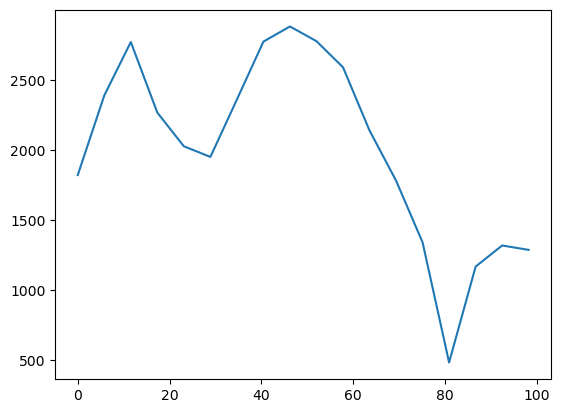

In [18]:
TRAVERSAL_INDEX = 11
print(f"Traversal name: {api.traversal_list[TRAVERSAL_INDEX]}")
traversal = api.get_traversal_data(TRAVERSAL_INDEX)
timeseq, ds = dtw_matching_distance_abs(template, 
                          traversal, 
                          downsampling_coefficient=10, 
                          step_coefficient=0.5,
                          perform_gaussian_filtering=True, 
                          gaussian_filter_sigma=1.0)
plt.plot(timeseq, ds)

In [14]:
from scipy.signal import find_peaks, peak_prominences

def max_peak_prominence(signal, wlen):
    peaks, _ = find_peaks(signal)
    prominences = peak_prominences(signal, peaks)[0]
    max_prominence = max(prominences)
    return max_prominence

In [15]:
import math

def calculate_direction(magdata: MagRetraceData):
    mag_x = magdata.mag_x
    mag_y = magdata.mag_y
    mag_z = magdata.mag_z
    angle = np.arctan2(mag_y, mag_x)
    return angle

In [29]:
api.list_template_titles()

Available template titles:
  0 - cb_g_exit_entering_template_2023324_1557
  1 - cb_g_exit_entering_template_2023327_1214
  2 - cb_g_exit_entering_template_2023328_1631
  3 - cb_g_exit_entering_template_45_deg_holding_2023327_1219
  4 - cb_g_exit_entering_template_in_pocket_2023327_1215
  5 - cb_g_exit_exiting_template_2023327_1216
  6 - cb_g_exit_template_1_2023322_1146
  7 - cb_g_exit_template_2023322_1344
  8 - cb_g_exit_template_2_2023322_1147
  9 - cb_g_exit_template_2_2023322_1344
  10 - cb_g_exit_template_3_2023322_1148
  11 - cb_lg_exit_entering_template_2023327_1221
  12 - cb_lg_exit_template_2023323_1225
  13 - composite_bldg_lg_exit_template_2023323_1226
  14 - su_canteen_entrance_template_2023327_1223


In [30]:
cb_template_names = [
    "cb_g_exit_entering_template_2023324_1557",
    "cb_g_exit_entering_template_2023327_1214",
    "cb_g_exit_entering_template_2023328_1631",
    "cb_g_exit_entering_template_45_deg_holding_2023327_1219",
    "cb_g_exit_entering_template_in_pocket_2023327_1215",
    "cb_g_exit_template_1_2023322_1146",
    "cb_g_exit_template_2023322_1344",
    "cb_g_exit_template_2_2023322_1147",
    "cb_g_exit_template_2_2023322_1344",
    "cb_g_exit_template_3_2023322_1148"
]
cb_templates = [
    api.get_template_data(name) for name in cb_template_names
]
cb_angles = [
    calculate_direction(template) for template in cb_templates
]

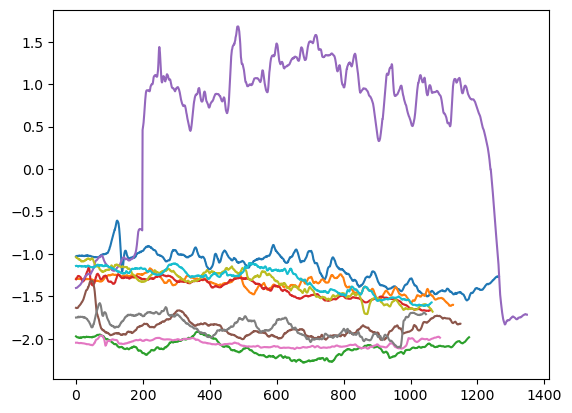

In [31]:
for i, angle in enumerate(cb_angles):
    plt.plot(np.rad2deg(angle), label=cb_template_names[i])

We can hence observe that the value itself is not important - it is the "amount-of-drop" that makes a relatively robust feature.

We have "prominence" in signalprocessing that can do this task for us.